# Exercise 6

This week we will practice how to work with OpenStreetMap data and conduct network analysis in Python.

- Exercise 6 is due by Wed 19.12.

- Don't forget to check out the [hints for this week's exercise](https://automating-gis-processes.github.io/2018/lessons/L6/Exercise-6.html) if you're having trouble.

- Scores on this exercise are out of 20 points.

## Problem 1 (8 points)

There exists two csv-files in the [/data](/data) folder. The files contain coordinates of the
origin and destination points in certain area of the world.

1: Based on the coordinates found in the files, use some GIS technique to find out, where the points are located? You may for example detect the location by using geocoding techniques (see [hints](https://geopy.readthedocs.io/en/stable/index.html?highlight=reverse#module-geopy.geocoders)), or [visualization techniques](https://automating-gis-processes.github.io/2018/lessons/L6/Exercise-6.html) to plot the points with background map. Save the answer to a variable `area_of_interest` and print out the answer with command: `print("The points are located in: %s" % area_of_interest)`

In [28]:
### BEGIN SOLUTION

import pandas as pd
import geopandas as gpd
import mplleaflet
from shapely.geometry import Point

# Filepaths
origs_fp = "data/origins.csv"
dests_fp = "data/destinations.csv"

# Read files
origs = pd.read_csv(origs_fp)
dests = pd.read_csv(dests_fp)

# Create geometries
origs['geometry'] = origs.apply(lambda row: Point(row['x'], row['y']), axis=1)
dests['geometry'] = dests.apply(lambda row: Point(row['x'], row['y']), axis=1)

# Make GeoDataFrames
origs = gpd.GeoDataFrame(origs, geometry='geometry', crs={'init': 'epsg:4326'})
dests = gpd.GeoDataFrame(dests, geometry='geometry', crs={'init': 'epsg:4326'})

# Alternative 1: Use reverse Geocoding to find out the location
# -------------------------------------------------------------

# Reverse geocode first 5 rows
origs_geocoded = gpd.tools.reverse_geocode(origs['geometry'].head(), provider='nominatim', user_agent = 'autogis_HT')
dests_geocoded = gpd.tools.reverse_geocode(dests['geometry'].head(), provider='nominatim', user_agent = 'autogis_HT')

# Check the results
#print(origs_geocoded)
#print(dests_geocoded)

# Answer
area_of_interest = "Tallinn, Estonia"

# Alternative 2: Use visualization to check the locations
combined = origs.append(dests)
ax = combined.plot(color='red', markersize=10)
mplleaflet.display(fig=ax.figure, crs=combined.crs)

### END SOLUTION

2: Retrieve OpenStreetMap data (only streets that can be driven with car) from the area where the points are located. You should use a Polygon specifying the extent where all the points are located to fetch the data with `.graph_from_polygon()` function (see [docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_polygon)).

In [39]:
### BEGIN SOLUTION
import osmnx  as ox

# Retrieve the drivable roads from Tallinn using the bounding box
# ---------------------------------------------------------------

# Alternative 1: Use bounding box Polygon

# Merge all points together
combined = origs.append(dests)

# Calculate the convex hull
hull = combined.unary_union.convex_hull

# Fetch the graph using the Polygon
graph = ox.graph_from_polygon(hull)

# Alternative 2 (should not be used but as an example): Using place name - You should check from https://nominatim.openstreetmap.org that the name you look for is area type
#graph2 = ox.graph_from_place("Tallinn, Kesklinna linnaosa, Tallinn, Harju maakond, Estonia", network_type="drive")

### END SOLUTION

3: Reproject the data into UTM projection, and plot:
  - the street network (with `gray` color and line width of `0.5` and alpha set to `0.7`)
  - the origin points (with `red` color)
  - destination points (with `blue` color)
  
In the end you should end up having a map that looks something like following:

![](img/route_network_with_OD_points.png)

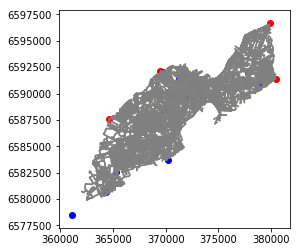

In [40]:
### BEGIN SOLUTION

# Reproject the graph
graph_proj = ox.project_graph(graph)

# Get the GeoDataFrame
edges = ox.graph_to_gdfs(graph_proj, nodes=False)

# Get CRS info
CRS = edges.crs

# Reproject all data
origs = origs.to_crs(crs=CRS)
dests = dests.to_crs(crs=CRS)

# Plot
ax = edges.plot(color='gray', linewidth=0.5, alpha=0.7)
ax = origs.plot(ax=ax, color='red')
ax = dests.plot(ax=ax, color='blue')

### END SOLUTION

### Done!

That's it! Now you can continue with problem 2. 

## Problem 2 (12 points)

In this problem we practice conducting shortest path routing.

### Steps

1: Calculate the shortest paths between all origin points (16) and destination points (20) using the `distance` of the road segments as the impedance measure (in total 320 routes). To be able to find the shortest paths, you should find the nearest nodes from the graph for both origin and destination points. Notice: if the closest node is the same for both origin and destination point, you should skip the shortest path calculation. After the routing, you should add the shortest path routes as LineString geometries into a GeoDataFrame called `routes`. You should use the projected graph as the network for the analyses:

In [71]:
### BEGIN SOLUTION
import networkx as nx
from shapely.geometry import LineString

# Create a GeoDataFrame for the results
routes = gpd.GeoDataFrame()

# Get nodes from the graph
nodes = ox.graph_to_gdfs(graph_proj, edges=False)

# Iterate over origins and destinations
for oidx, origin in origs.iterrows():
    
    # Find closest node from the graph --> point = (latitude, longitude)
    closest_origin_node = ox.get_nearest_node(G=graph_proj, point=(origin.geometry.y, origin.geometry.x), method='euclidean')
    
    # Iterate over targets
    for tidx, target in dests.iterrows():
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_target_node = ox.get_nearest_node(graph_proj, point=(target.geometry.y, target.geometry.x), method='euclidean')
        
        # Check if origin and target nodes are the same --> if they are --> skip
        if closest_origin_node == closest_target_node:
            print("Same origin and destination node. Skipping ..")
            continue
            
        # Find the shortest path between the points
        route = nx.shortest_path(graph_proj, 
                                 source=closest_origin_node, 
                                 target=closest_target_node, weight='length')
        
        # Extract the nodes of the route
        route_nodes = nodes.loc[route]
        
        # Create a LineString out of the route
        path = LineString(list(route_nodes.geometry.values))
        
        # Append the result into the GeoDataFrame
        routes = routes.append([[path]], ignore_index=True)

# Add a column name
routes.columns = ['geometry']

# Set coordinate reference system
routes.crs = nodes.crs

# Set geometry
routes = routes.set_geometry('geometry')
        
### END SOLUTION

2: Calculate the distance of the routes in meters into a column called `route_dist`.
 

In [82]:
### BEGIN SOLUTION

# Calculate the distance
routes['route_dist'] = routes.length

### END SOLUTION

 3: Plot all the routes on top of the street network. In the end you should have something like following:
 
 ![](img/routings.png)

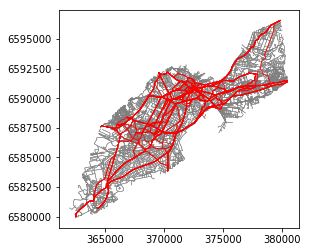

In [85]:
### BEGIN SOLUTION

# Plot network and the routes
ax = edges.plot(color='gray', linewidth=0.5)
ax = routes.plot(ax=ax, color='red', linewidth=0.8, alpha=0.6)

### END SOLUTION

 4: Calculate the total distance of all the routes (i.e. sum of all route distances) and print the answer to the screen in kilometers. 

In [88]:
### BEGIN SOLUTION

# Calculate total distance 
tot_dist = routes['route_dist'].sum()
print("Total distance of all routes is: %.0f kilometers" % (tot_dist / 1000))
### END SOLUTION

Total distance of all routes is: 2280 kilometers


### Done!

That's it! Now you have finished all the practical exercises of the course (except final assignment), congratulations! :)